In [3]:
import os
import h5py
import argparse
import numpy as np
import matplotlib.pyplot as plt

from shutil import copyfile
from tabulate import tabulate

In [4]:
DEMO = -1
ROLLOUT = 0
INTV = 1
FULL_ROLLOUT = 2

PRE_INTV = -10

In [12]:
base_path = "/home/huihanl/huihan_hitl"

In [8]:
names = {
    "-1": "Demo",
    "0": "Rollout",
    "1": "Intv",
    "-10": "Preintv",
    -1: "Demo",
    0: "Rollout",
    1: "Intv",
    -10: "Preintv", 
}

In [9]:
def get_categories_ratio(dataset, dataset_name):
    out_dataset_path = os.path.expanduser(dataset)

    f = h5py.File(out_dataset_path, "r+")

    demos = sorted(list(f["data"].keys()))

    intv_labels_all = []
    
    for ep in demos:
        # store trajectory
        ep_data_grp = f["data/{}".format(ep)]
        random_obs_key = list(ep_data_grp["obs"].keys())[0]
        num_samples = len(ep_data_grp["obs/{}".format(random_obs_key)])
        intv_labels = ep_data_grp["intv_labels"][()]
        intv_labels_all.extend(intv_labels)
    
    unique, counts = np.unique(intv_labels_all, return_counts=True)
    total = len(intv_labels_all)
    
    unique = [names[u] for u in unique]
    counts_ratio = np.array([c / total for c in counts])
    
    headers = ["Category", "Count", "Percentage"]
    
    data = zip(
        unique + ["Total"],
        list(counts) + [sum(counts)], 
        list(counts_ratio) + [1]
      )
#     print("======================================")
#     print()
#     print("\033[94mDataset: ", dataset_name)
#     print()
#     print("\033[38;2;0;0;0m{}".format(tabulate(data, headers=headers)))
#     print()
#     print("======================================")
#     print()
#     print()
    
    return unique, counts, counts_ratio

# Define Datasets Here:

In [13]:
datasets = [
            "0715_hh_epoch600_round01.hdf5",
            "0725_ours_round012.hdf5",
            "0725_ours_round0123.hdf5",
            "0726_round01_0.2ratio.hdf5",
           ]
datasets = [os.path.join(base_path, d) for d in datasets]
dataset_names = [
            "round01",
            "round012",
            "round0123",
            "round01_0.2ratio"
           ]

In [5]:
datasets = [
            "lance_toolhang_100_hq_128.hdf5",
           ]
datasets = [os.path.join("/home/huihanl", d) for d in datasets]
dataset_names = [
            "toolhang_round01"
           ]

In [33]:
datasets_per_round = [
            "0715_hh_epoch600_copy.hdf5",
            "0725_ours_round2.hdf5",
            "0725_ours_round3.hdf5",
           ]
datasets_per_round = [os.path.join(base_path, d) for d in datasets_per_round]
dataset_names_per_round = [
            "round1",
            "round2",
            "round3",
           ]

## 4 Categories Ratio

In [10]:
for i in range(len(datasets)):
    d = datasets[i]
    d_name = dataset_names[i]
    unique, counts, counts_ratio = get_categories_ratio(d, d_name)

KeyError: "Unable to open object (object 'intv_labels' doesn't exist)"

In [41]:
for i in range(len(datasets_per_round)):
    d = datasets_per_round[i]
    d_name = dataset_names_per_round[i]
    unique, counts, counts_ratio = get_categories_ratio(d, d_name)


Dataset:  round1

 Category      Count    Percentage
----------  -------  ------------
Preintv        1827      0.108569
Rollout       12617      0.749762
Intv           2384      0.141669
Total         16828      1




Dataset:  round2

 Category      Count    Percentage
----------  -------  ------------
Preintv        2089     0.0714359
Rollout       24790     0.847724
Intv           2364     0.0808399
Total         29243     1




Dataset:  round3

 Category      Count    Percentage
----------  -------  ------------
Preintv        1534     0.0311643
Rollout       45338     0.921073
Intv           2351     0.0477622
Total         49223     1





# 1. Method: Prenorm - using one ratio r

In [63]:
def prenorm(d, d_name, r, demos=1):
    unique, counts, counts_ratio = get_categories_ratio(d, d_name)
    categories = unique
    percentage = counts_ratio
    weight_factor = 1. / counts_ratio
    
    adjusted_factor = weight_factor * np.array([0.005, demos, r, 1])
    
    final_weight = percentage * adjusted_factor
    normalize_ratio = sum(final_weight)
    normalized_weight = adjusted_factor / normalize_ratio

    final_percentage = percentage * normalized_weight

    data = zip(categories, 
               percentage, 
               weight_factor, 
               adjusted_factor, 
               final_weight,
               final_percentage,
              )
    
    headers = ["Category", 
           "Percentage", 
           "Prenorm Weight", 
           "Adjusted Weight", 
           "Final Weight",
           "Final Percentage",
          ]

    print("======================================")
    print()
    print("\033[94mR: {}, D: {}".format(r, demos))
    print()
    print("\033[38;2;0;0;0m{}".format(tabulate(data, headers=headers)))
    print()
    print("======================================")
    print()

In [185]:
def prenorm_shorter(d, d_name, r, demos=1):
    unique, counts, counts_ratio = get_categories_ratio(d, d_name)
    categories = unique
    percentage = counts_ratio
    weight_factor = 1. / counts_ratio
    
    adjusted_factor = weight_factor * np.array([0.005, demos, r, 1])
    
    final_weight = percentage * adjusted_factor
    normalize_ratio = sum(final_weight)
    normalized_weight = adjusted_factor / normalize_ratio

    final_percentage = percentage * normalized_weight

    data = zip(categories, 
               percentage, 
#                weight_factor, 
#                adjusted_factor, 
#                final_weight,
               final_percentage,
              )
    
    headers = ["Category", 
               "Percentage", 
#            "Prenorm Weight", 
#            "Adjusted Weight", 
#            "Final Weight",
               "Final Percentage",
              ]

    print("======================================")
    print()
    print("\033[94mR: {}, D: {}".format(r, demos))
    print()
    print("\033[38;2;0;0;0m{}".format(tabulate(data, headers=headers)))
    print()
    print("\033[92mFinal percentage: ", final_percentage)
    #print("======================================")
    print()
    print()

In [166]:
def get_weight(final_percentage, orig_percentage):
    nonadjusted_weight = final_percentage / orig_percentage

In [173]:
#final_percentage = np.array([0.002, 0.4, 0.1-0.002, 0.5])
final_percentage = np.array([0.002, 0.433839, 0.130152, 0.433839])
orig_percentage = np.array([0.0739049, 0.130523, 0.705966, 0.0896069])
final_percentage / orig_percentage

array([0.02706181, 3.32385097, 0.18436015, 4.84158028])

In [176]:
final_percentage = np.array([0.002, 0.3, 0.2-0.002, 0.5])
#final_percentage = np.array([0.002, 0.433839, 0.130152, 0.433839])
orig_percentage = np.array([0.0739049, 0.130523, 0.705966, 0.0896069])
final_percentage / orig_percentage

array([0.02706181, 2.29844548, 0.28046676, 5.57992744])

In [175]:
#final_percentage = np.array([0.002, 0.4, 0.1-0.002, 0.5])
final_percentage = np.array([0.002, 0.349127, 0.149626, 0.498753])
orig_percentage = np.array([0.0739049, 0.130523, 0.705966, 0.0896069])
final_percentage / orig_percentage

array([0.02706181, 2.67483126, 0.21194505, 5.5660111 ])

In [172]:
for i in [1]:
    d = datasets[i]
    d_name = dataset_names[i]
    r_lst = [0.3]
    print()
    print("\033[95mDataset: ", d_name)
    for r in r_lst:
        prenorm(d, d_name, r)
        prenorm(d, d_name, r, demos=0.7)
        prenorm(d, d_name, r, demos=0.2)


Dataset:  round012

R: 0.3, D: 1

Category      Percentage    Prenorm Weight    Adjusted Weight    Final Weight    Final Percentage
----------  ------------  ----------------  -----------------  --------------  ------------------
Preintv        0.0739049          13.5309           0.0676545           0.005           0.0021692
Demo           0.130523            7.66151          7.66151             1               0.433839
Rollout        0.705966            1.4165           0.42495             0.3             0.130152
Intv           0.0896069          11.1599          11.1599              1               0.433839



R: 0.3, D: 0.7

Category      Percentage    Prenorm Weight    Adjusted Weight    Final Weight    Final Percentage
----------  ------------  ----------------  -----------------  --------------  ------------------
Preintv        0.0739049          13.5309           0.0676545           0.005          0.00249377
Demo           0.130523            7.66151          5.36306        

In [186]:
for i in [1]:
    d = datasets[i]
    d_name = dataset_names[i]
    r_lst = [0.8]
    print()
    print("\033[95mDataset: ", d_name)
    for r in r_lst:
        prenorm_shorter(d, d_name, r)
        prenorm_shorter(d, d_name, r, demos=0.7)
        prenorm_shorter(d, d_name, r, demos=0.2)


Dataset:  round012

R: 0.8, D: 1

Category      Percentage    Final Percentage
----------  ------------  ------------------
Preintv        0.0739049          0.00178253
Demo           0.130523           0.356506
Rollout        0.705966           0.285205
Intv           0.0896069          0.356506

Final percentage:  [0.00178253 0.35650624 0.28520499 0.35650624]



R: 0.8, D: 0.7

Category      Percentage    Final Percentage
----------  ------------  ------------------
Preintv        0.0739049          0.00199601
Demo           0.130523           0.279441
Rollout        0.705966           0.319361
Intv           0.0896069          0.399202

Final percentage:  [0.00199601 0.27944112 0.31936128 0.3992016 ]



R: 0.8, D: 0.2

Category      Percentage    Final Percentage
----------  ------------  ------------------
Preintv        0.0739049          0.00249377
Demo           0.130523           0.0997506
Rollout        0.705966           0.399002
Intv           0.0896069          0.498753

F

In [187]:
for i in [1]:
    d = datasets[i]
    d_name = dataset_names[i]
    r_lst = [0.4]
    print()
    print("\033[95mDataset: ", d_name)
    for r in r_lst:
        prenorm_shorter(d, d_name, r)
        prenorm_shorter(d, d_name, r, demos=0.7)
        prenorm_shorter(d, d_name, r, demos=0.5)
        prenorm_shorter(d, d_name, r, demos=0.2)


Dataset:  round012

R: 0.4, D: 1

Category      Percentage    Final Percentage
----------  ------------  ------------------
Preintv        0.0739049            0.002079
Demo           0.130523             0.4158
Rollout        0.705966             0.16632
Intv           0.0896069            0.4158

Final percentage:  [0.002079   0.41580042 0.16632017 0.41580042]



R: 0.4, D: 0.7

Category      Percentage    Final Percentage
----------  ------------  ------------------
Preintv        0.0739049           0.0023753
Demo           0.130523            0.332542
Rollout        0.705966            0.190024
Intv           0.0896069           0.475059

Final percentage:  [0.0023753  0.33254157 0.19002375 0.47505938]



R: 0.4, D: 0.5

Category      Percentage    Final Percentage
----------  ------------  ------------------
Preintv        0.0739049          0.00262467
Demo           0.130523           0.262467
Rollout        0.705966           0.209974
Intv           0.0896069          0.524934

In [188]:
for i in [1]:
    d = datasets[i]
    d_name = dataset_names[i]
    r_lst = [0.4, 0.35]
    print()
    print("\033[95mDataset: ", d_name)
    for r in r_lst:
        prenorm_shorter(d, d_name, r)
        prenorm_shorter(d, d_name, r, demos=0.7)
        prenorm_shorter(d, d_name, r, demos=0.5)
        #prenorm_shorter(d, d_name, r, demos=0.2)


Dataset:  round012

R: 0.4, D: 1

Category      Percentage    Final Percentage
----------  ------------  ------------------
Preintv        0.0739049            0.002079
Demo           0.130523             0.4158
Rollout        0.705966             0.16632
Intv           0.0896069            0.4158

Final percentage:  [0.002079   0.41580042 0.16632017 0.41580042]



R: 0.4, D: 0.7

Category      Percentage    Final Percentage
----------  ------------  ------------------
Preintv        0.0739049           0.0023753
Demo           0.130523            0.332542
Rollout        0.705966            0.190024
Intv           0.0896069           0.475059

Final percentage:  [0.0023753  0.33254157 0.19002375 0.47505938]



R: 0.4, D: 0.5

Category      Percentage    Final Percentage
----------  ------------  ------------------
Preintv        0.0739049          0.00262467
Demo           0.130523           0.262467
Rollout        0.705966           0.209974
Intv           0.0896069          0.524934

In [139]:
for i in [1]:
    d = datasets[i]
    d_name = dataset_names[i]
    r_lst = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
    print()
    print("\033[95mDataset: ", d_name)
    for r in r_lst:
        #prenorm_shorter(d, d_name, r)
        #prenorm_shorter(d, d_name, r, demos=0.7)
        prenorm_shorter(d, d_name, r, demos=0.5)
        #prenorm_shorter(d, d_name, r, demos=0.2)


Dataset:  round012

R: 0.2, D: 0.5

Category      Percentage    Final Percentage
----------  ------------  ------------------
Preintv        0.0739049          0.00293255
Demo           0.130523           0.293255
Rollout        0.705966           0.117302
Intv           0.0896069          0.58651

Final percentage:  [0.00293255 0.29325513 0.11730205 0.58651026]



R: 0.3, D: 0.5

Category      Percentage    Final Percentage
----------  ------------  ------------------
Preintv        0.0739049          0.00277008
Demo           0.130523           0.277008
Rollout        0.705966           0.166205
Intv           0.0896069          0.554017

Final percentage:  [0.00277008 0.27700831 0.16620499 0.55401662]



R: 0.4, D: 0.5

Category      Percentage    Final Percentage
----------  ------------  ------------------
Preintv        0.0739049          0.00262467
Demo           0.130523           0.262467
Rollout        0.705966           0.209974
Intv           0.0896069          0.524934

F

# 2. Method: Using Category Ratio

In [82]:
def cat_ratio(d, d_name, r):
    unique, counts, counts_ratio = get_categories_ratio(d, d_name)
    categories = unique
    percentage = counts_ratio
    weight_factor = 1. / counts_ratio
    
    adjusted_factor = [0.1 * r, weight_factor[1], r, weight_factor[3]]
    
    final_weight = percentage * adjusted_factor
    normalize_ratio = sum(final_weight)
    normalized_weight = adjusted_factor / normalize_ratio

    final_percentage = percentage * normalized_weight

    data = zip(categories, 
               percentage, 
#                weight_factor, 
#                adjusted_factor, 
#                final_weight,
               final_percentage,
              )
    headers = ["Category", 
               "Percentage", 
#            "Prenorm Weight", 
#            "Adjusted Weight", 
#            "Final Weight",
               "Final Percentage",
              ]
    print("======================================")
    print()
    print("\033[94mr: {}".format(r))
    print()
    print("\033[38;2;0;0;0m{}".format(tabulate(data, headers=headers)))
    print()
    print("======================================")
    print()


### Best category ratio:

In [86]:
for i in [1]:
    d = datasets[i]
    d_name = dataset_names[i]
    r_lst = [0.8]
    print()
    print("\033[95mDataset: ", d_name)
    for r in r_lst:
        cat_ratio(d, d_name, r)


Dataset:  round012

r: 0.8

Category      Percentage    Final Percentage
----------  ------------  ------------------
Preintv        0.0739049          0.00229993
Demo           0.130523           0.389001
Rollout        0.705966           0.219697
Intv           0.0896069          0.389001




# 3. Method: Hardcoded Weights

In [122]:
def hardcoded_weights(d, d_name, weight_dict):
    unique, counts, counts_ratio = get_categories_ratio(d, d_name)
    categories = unique
    percentage = counts_ratio
    #weight_factor = 1. / counts_ratio
    
    adjusted_factor = [weight_dict["preintv"], 
                       weight_dict["demos"],  
                       weight_dict["rollouts"], 
                       weight_dict["intv"],
                      ]
    
    final_weight = percentage * adjusted_factor
    normalize_ratio = sum(final_weight)
    normalized_weight = adjusted_factor / normalize_ratio

    final_percentage = percentage * normalized_weight

    data = zip(categories, 
               percentage, 
               #weight_factor, 
               adjusted_factor, 
               final_weight,
               final_percentage,
              )
    headers = ["Category", 
               "Percentage", 
           #"Prenorm Weight", 
           "Adjusted Weight", 
           "Final Weight",
               "Final Percentage",
              ]
    print("======================================")
    print()
    print("\033[94mweight_dict: {}".format(weight_dict))
    print()
    print("\033[38;2;0;0;0m{}".format(tabulate(data, headers=headers)))
    print()
    #print("======================================")
    print()
    print("\033[92mFinal percentage: ", final_percentage)
    print()
    print()

## Best hardcoded weights:

In [123]:
for i in [1]:
    d = datasets[i]
    d_name = dataset_names[i]
    four_cats = [
#         [0.1, 10, 1, 20], 
#         [0.1, 5, 1, 20],
#         [0.1, 1, 1, 20],
#         [0.1, 1, 1, 10],
#         [0.1, 1, 1, 20],
        [1, 15, 1, 0.1],
        [5, 15, 1, 0.1],
        [10, 15, 1, 0.1], # bad
    ]
    print()
    print("\033[95mDataset: ", d_name)
    for cat in four_cats:
        weight_dict = {
           "demos": cat[0],
           "intv": cat[1],
           "rollouts": cat[2],
           "preintv": cat[3],
        }
        hardcoded_weights(d, d_name, weight_dict)


Dataset:  round012

weight_dict: {'demos': 1, 'intv': 15, 'rollouts': 1, 'preintv': 0.1}

Category      Percentage    Adjusted Weight    Final Weight    Final Percentage
----------  ------------  -----------------  --------------  ------------------
Preintv        0.0739049                0.1      0.00739049          0.00337777
Demo           0.130523                 1        0.130523            0.0596543
Rollout        0.705966                 1        0.705966            0.322656
Intv           0.0896069               15        1.3441              0.614312


Final percentage:  [0.00337777 0.05965432 0.32265605 0.61431186]



weight_dict: {'demos': 5, 'intv': 15, 'rollouts': 1, 'preintv': 0.1}

Category      Percentage    Adjusted Weight    Final Weight    Final Percentage
----------  ------------  -----------------  --------------  ------------------
Preintv        0.0739049                0.1      0.00739049          0.00272705
Demo           0.130523                 5        0.652

In [124]:
for i in [1]:
    d = datasets[i]
    d_name = dataset_names[i]
    four_cats = [
#         [0.1, 10, 1, 20], 
#         [0.1, 5, 1, 20],
#         [0.1, 1, 1, 20],
#         [0.1, 1, 1, 10],
#         [0.1, 1, 1, 20],
        [1, 5, 1, 0.1],
        [5, 5, 1, 0.1], # bad
        [10, 5, 1, 0.1], # bad
    ]
    print()
    print("\033[95mDataset: ", d_name)
    for cat in four_cats:
        weight_dict = {
           "demos": cat[0],
           "intv": cat[1],
           "rollouts": cat[2],
           "preintv": cat[3],
        }
        hardcoded_weights(d, d_name, weight_dict)


Dataset:  round012

weight_dict: {'demos': 1, 'intv': 5, 'rollouts': 1, 'preintv': 0.1}

Category      Percentage    Adjusted Weight    Final Weight    Final Percentage
----------  ------------  -----------------  --------------  ------------------
Preintv        0.0739049                0.1      0.00739049          0.00572058
Demo           0.130523                 1        0.130523            0.10103
Rollout        0.705966                 1        0.705966            0.54645
Intv           0.0896069                5        0.448034            0.346799


Final percentage:  [0.00572058 0.10103046 0.54644976 0.34679919]



weight_dict: {'demos': 5, 'intv': 5, 'rollouts': 1, 'preintv': 0.1}

Category      Percentage    Adjusted Weight    Final Weight    Final Percentage
----------  ------------  -----------------  --------------  ------------------
Preintv        0.0739049                0.1      0.00739049          0.00407413
Demo           0.130523                 5        0.652613  

In [125]:
for i in [1]:
    d = datasets[i]
    d_name = dataset_names[i]
    four_cats = [
        [1, 10, 1, 0.1],
        [10, 10, 1, 0.1], # bad
    ]
    print()
    print("\033[95mDataset: ", d_name)
    for cat in four_cats:
        weight_dict = {
           "demos": cat[0],
           "intv": cat[1],
           "rollouts": cat[2],
           "preintv": cat[3],
        }
        hardcoded_weights(d, d_name, weight_dict)


Dataset:  round012

weight_dict: {'demos': 1, 'intv': 10, 'rollouts': 1, 'preintv': 0.1}

Category      Percentage    Adjusted Weight    Final Weight    Final Percentage
----------  ------------  -----------------  --------------  ------------------
Preintv        0.0739049                0.1      0.00739049          0.00424754
Demo           0.130523                 1        0.130523            0.0750152
Rollout        0.705966                 1        0.705966            0.40574
Intv           0.0896069               10        0.896069            0.514998


Final percentage:  [0.00424754 0.07501524 0.4057396  0.51499762]



weight_dict: {'demos': 10, 'intv': 10, 'rollouts': 1, 'preintv': 0.1}

Category      Percentage    Adjusted Weight    Final Weight    Final Percentage
----------  ------------  -----------------  --------------  ------------------
Preintv        0.0739049                0.1      0.00739049          0.00253564
Demo           0.130523                10        1.305

In [126]:
for i in [1]:
    d = datasets[i]
    d_name = dataset_names[i]
    four_cats = [
        [5, 25, 1, 0.1],
        [1, 25, 1, 0.1], # bad
    ]
    print()
    print("\033[95mDataset: ", d_name)
    for cat in four_cats:
        weight_dict = {
           "demos": cat[0],
           "intv": cat[1],
           "rollouts": cat[2],
           "preintv": cat[3],
        }
        hardcoded_weights(d, d_name, weight_dict)


Dataset:  round012

weight_dict: {'demos': 5, 'intv': 25, 'rollouts': 1, 'preintv': 0.1}

Category      Percentage    Adjusted Weight    Final Weight    Final Percentage
----------  ------------  -----------------  --------------  ------------------
Preintv        0.0739049                0.1      0.00739049          0.00204942
Demo           0.130523                 5        0.652613            0.180973
Rollout        0.705966                 1        0.705966            0.195768
Intv           0.0896069               25        2.24017             0.62121


Final percentage:  [0.00204942 0.18097265 0.19576761 0.62121033]



weight_dict: {'demos': 1, 'intv': 25, 'rollouts': 1, 'preintv': 0.1}

Category      Percentage    Adjusted Weight    Final Weight    Final Percentage
----------  ------------  -----------------  --------------  ------------------
Preintv        0.0739049                0.1      0.00739049          0.00239636
Demo           0.130523                 1        0.13052

In [127]:
for i in [1]:
    d = datasets[i]
    d_name = dataset_names[i]
    four_cats = [
        [1, 20, 1, 0.1],
        [5, 20, 1, 0.1], 
        [10, 20, 1, 0.1], 
    ]
    print()
    print("\033[95mDataset: ", d_name)
    for cat in four_cats:
        weight_dict = {
           "demos": cat[0],
           "intv": cat[1],
           "rollouts": cat[2],
           "preintv": cat[3],
        }
        hardcoded_weights(d, d_name, weight_dict)


Dataset:  round012

weight_dict: {'demos': 1, 'intv': 20, 'rollouts': 1, 'preintv': 0.1}

Category      Percentage    Adjusted Weight    Final Weight    Final Percentage
----------  ------------  -----------------  --------------  ------------------
Preintv        0.0739049                0.1      0.00739049          0.00280366
Demo           0.130523                 1        0.130523            0.0495151
Rollout        0.705966                 1        0.705966            0.267815
Intv           0.0896069               20        1.79214             0.679866


Final percentage:  [0.00280366 0.04951509 0.26781534 0.67986592]



weight_dict: {'demos': 5, 'intv': 20, 'rollouts': 1, 'preintv': 0.1}

Category      Percentage    Adjusted Weight    Final Weight    Final Percentage
----------  ------------  -----------------  --------------  ------------------
Preintv        0.0739049                0.1      0.00739049          0.00234017
Demo           0.130523                 5        0.652

In [128]:
for i in [1]:
    d = datasets[i]
    d_name = dataset_names[i]
    four_cats = [
        [15, 1, 1, 0.1],
        [15, 5, 1, 0.1], 
        [15, 10, 1, 0.1], 
        [15, 15, 1, 0.1], 
        [15, 20, 1, 0.1], 
    ]
    print()
    print("\033[95mDataset: ", d_name)
    for cat in four_cats:
        weight_dict = {
           "demos": cat[0],
           "intv": cat[1],
           "rollouts": cat[2],
           "preintv": cat[3],
        }
        hardcoded_weights(d, d_name, weight_dict)


Dataset:  round012

weight_dict: {'demos': 15, 'intv': 1, 'rollouts': 1, 'preintv': 0.1}

Category      Percentage    Adjusted Weight    Final Weight    Final Percentage
----------  ------------  -----------------  --------------  ------------------
Preintv        0.0739049                0.1      0.00739049          0.00267694
Demo           0.130523                15        1.95784             0.709156
Rollout        0.705966                 1        0.705966            0.25571
Intv           0.0896069                1        0.0896069           0.0324568


Final percentage:  [0.00267694 0.70915586 0.25571037 0.03245683]



weight_dict: {'demos': 15, 'intv': 5, 'rollouts': 1, 'preintv': 0.1}

Category      Percentage    Adjusted Weight    Final Weight    Final Percentage
----------  ------------  -----------------  --------------  ------------------
Preintv        0.0739049                0.1      0.00739049          0.00236933
Demo           0.130523                15        1.9578

In [140]:
for i in [2]:
    d = datasets[i]
    d_name = dataset_names[i]
    four_cats = [
        [1, 15, 1, 0.1], # good
        [5, 15, 1, 0.1],
        [10, 15, 1, 0.1],
    ]
    print()
    print("\033[95mDataset: ", d_name)
    for cat in four_cats:
        weight_dict = {
           "demos": cat[0],
           "intv": cat[1],
           "rollouts": cat[2],
           "preintv": cat[3],
        }
        hardcoded_weights(d, d_name, weight_dict)


Dataset:  round0123

weight_dict: {'demos': 1, 'intv': 15, 'rollouts': 1, 'preintv': 0.1}

Category      Percentage    Adjusted Weight    Final Weight    Final Percentage
----------  ------------  -----------------  --------------  ------------------
Preintv        0.0533216                0.1      0.00533216          0.00277084
Demo           0.0676646                1        0.0676646           0.0351618
Rollout        0.809559                 1        0.809559            0.420685
Intv           0.069455                15        1.04183             0.541382


Final percentage:  [0.00277084 0.03516175 0.42068524 0.54138217]



weight_dict: {'demos': 5, 'intv': 15, 'rollouts': 1, 'preintv': 0.1}

Category      Percentage    Adjusted Weight    Final Weight    Final Percentage
----------  ------------  -----------------  --------------  ------------------
Preintv        0.0533216                0.1      0.00533216          0.00242919
Demo           0.0676646                5        0.33

In [182]:
for i in [3]:
    d = datasets[i]
    d_name = dataset_names[i]
    four_cats = [
        [1, 5, 1, 0.1],
        [1, 10, 1, 0.1],
        [1, 15, 1, 0.1],
        [5, 15, 1, 0.1],
    ]
    print()
    print("\033[95mDataset: ", d_name)
    for cat in four_cats:
        weight_dict = {
           "demos": cat[0],
           "intv": cat[1],
           "rollouts": cat[2],
           "preintv": cat[3],
        }
        hardcoded_weights(d, d_name, weight_dict)


Dataset:  round01_0.2ratio

weight_dict: {'demos': 1, 'intv': 5, 'rollouts': 1, 'preintv': 0.1}

Category      Percentage    Adjusted Weight    Final Weight    Final Percentage
----------  ------------  -----------------  --------------  ------------------
Preintv        0.0656518                0.1      0.00656518          0.00518349
Demo           0.411275                 1        0.411275            0.324719
Rollout        0.441663                 1        0.441663            0.348712
Intv           0.0814106                5        0.407053            0.321386


Final percentage:  [0.00518349 0.32471923 0.34871164 0.32138564]



weight_dict: {'demos': 1, 'intv': 10, 'rollouts': 1, 'preintv': 0.1}

Category      Percentage    Adjusted Weight    Final Weight    Final Percentage
----------  ------------  -----------------  --------------  ------------------
Preintv        0.0656518                0.1      0.00656518          0.00392277
Demo           0.411275                 1       

In [164]:
for i in [3]:
    d = datasets[i]
    d_name = dataset_names[i]
    print()
    print("\033[95mDataset: ", d_name)
    r_lst = [0.3, 0.5]
    for r in r_lst:
        prenorm(d, d_name, r)


Dataset:  round01_0.2ratio

R: 0.3, D: 1

Category      Percentage    Prenorm Weight    Adjusted Weight    Final Weight    Final Percentage
----------  ------------  ----------------  -----------------  --------------  ------------------
Preintv        0.0656518          15.2319           0.0761594           0.005           0.0021692
Demo           0.411275            2.43146          2.43146             1               0.433839
Rollout        0.441663            2.26417          0.679251            0.3             0.130152
Intv           0.0814106          12.2834          12.2834              1               0.433839



R: 0.5, D: 1

Category      Percentage    Prenorm Weight    Adjusted Weight    Final Weight    Final Percentage
----------  ------------  ----------------  -----------------  --------------  ------------------
Preintv        0.0656518          15.2319           0.0761594           0.005          0.00199601
Demo           0.411275            2.43146          2.43146  

In [149]:
datasets = [
            "0715_hh_epoch600_round01.hdf5",
           ]
datasets = [os.path.join(base_path, d) for d in datasets]
dataset_names = [
            "round01",
           ]

In [153]:
for i in [0]:
    d = datasets[i]
    d_name = dataset_names[i]
    r_lst = [0.4, 0.35]
    print()
    print("\033[95mDataset: ", d_name)
    for r in r_lst:
        prenorm_shorter(d, d_name, r)
        
        #prenorm_shorter(d, d_name, r, demos=0.7)
        #prenorm_shorter(d, d_name, r, demos=0.2)


Dataset:  round01

R: 0.4, D: 1

Category      Percentage    Final Percentage
----------  ------------  ------------------
Preintv        0.0769458            0.002079
Demo           0.291274             0.4158
Rollout        0.531376             0.16632
Intv           0.100404             0.4158

Final percentage:  [0.002079   0.41580042 0.16632017 0.41580042]



R: 0.35, D: 1

Category      Percentage    Final Percentage
----------  ------------  ------------------
Preintv        0.0769458          0.00212314
Demo           0.291274           0.424628
Rollout        0.531376           0.14862
Intv           0.100404           0.424628

Final percentage:  [0.00212314 0.42462845 0.14861996 0.42462845]




In [154]:
for i in [0]:
    d = datasets[i]
    d_name = dataset_names[i]
    r_lst = [1]
    print()
    print("\033[95mDataset: ", d_name)
    for r in r_lst:
        cat_ratio(d, d_name, r)


Dataset:  round01

r: 1

Category      Percentage    Final Percentage
----------  ------------  ------------------
Preintv        0.0769458          0.00303047
Demo           0.291274           0.393845
Rollout        0.531376           0.20928
Intv           0.100404           0.393845




In [343]:
for i in range(len(best_adjusted_r)):
    d = datasets[0]
    r = best_adjusted_r[i]
    unique, counts = get_categories_ratio(d)
    categories = unique
    percentage = counts
    weight_factor = 1. / counts
    
    adjusted_factor = weight_factor * np.array([0.005, 1, r, 1])
    
    final_weight = percentage * adjusted_factor
    normalize_ratio = sum(final_weight)
    normalized_weight = adjusted_factor / normalize_ratio
    print(normalized_weight)

    final_percentage = percentage * normalized_weight

    data = zip(categories, 
               percentage, 
               weight_factor, 
               adjusted_factor, 
               final_weight,
               final_percentage,
              )
    print("======================================")
    print()
    print("R: ", best_adjusted_r[i])
    print()
    print(tabulate(data, headers=headers))
    print()
    print("======================================")
    print()
    print()

[ 3561  6916 24165  4549]
[0.02495605 2.56993871 0.1471028  3.90716556]

R:  0.2

Category      Percentage    Prenorm Weight    Adjusted Weight    Final Weight    Final Percentage
----------  ------------  ----------------  -----------------  --------------  ------------------
Preintv        0.0908627          11.0056           0.0550281           0.005          0.00226757
Demo           0.176469            5.66671          5.66671             1              0.453515
Rollout        0.616596            1.62181          0.324362            0.2            0.0907029
Intv           0.116073            8.6153           8.6153              1              0.453515



[ 3561  6916 24165  4549]
[0.02387335 2.45844463 0.21108135 3.7376573 ]

R:  0.3

Category      Percentage    Prenorm Weight    Adjusted Weight    Final Weight    Final Percentage
----------  ------------  ----------------  -----------------  --------------  ------------------
Preintv        0.0908627          11.0056           0.

In [251]:
for i in range(len(datasets)):
    d = datasets[i]
    r = best_adjusted_r[i]
    unique, counts = get_categories_ratio(d)
    categories = unique
    percentage = counts
    weight_factor = 1. / counts
    
    adjusted_factor = [0.1, 5, 1, 15]
    
    final_weight = percentage * adjusted_factor
    normalize_ratio = sum(final_weight)
    normalized_weight = adjusted_factor / normalize_ratio

    final_percentage = percentage * normalized_weight

    data = zip(categories, 
               percentage, 
               weight_factor, 
               adjusted_factor, 
               final_weight,
               final_percentage,
              )
    print("======================================")
    print()
    print("Dataset: ", dataset_names[i])
    print()
    print(tabulate(data, headers=headers))
    print()
    print("======================================")
    print()
    print()

[ 3561  6916 24165  4549]

Dataset:  round01_250

Category      Percentage    Prenorm Weight    Adjusted Weight    Final Weight    Final Percentage
----------  ------------  ----------------  -----------------  --------------  ------------------
Preintv        0.0908627          11.0056                 0.1      0.00908627          0.00279654
Demo           0.176469            5.66671                5        0.882345            0.271565
Rollout        0.616596            1.62181                1        0.616596            0.189773
Intv           0.116073            8.6153                15        1.74109             0.535865



[ 1827  6916 12617  2384]

Dataset:  round01_150

Category      Percentage    Prenorm Weight    Adjusted Weight    Final Weight    Final Percentage
----------  ------------  ----------------  -----------------  --------------  ------------------
Preintv        0.0769458          12.9962                 0.1      0.00769458          0.00219751
Demo           0.2912

Dataset:  hh_600
3.433198380566802
9.95973154362416
2.9010067114093956
Dataset:  hh_2600
3.3558415268941584
13.660388463802237
4.070629782224838
Dataset:  hh_600_more_intv
3.245083863504916
5.824811834933818
1.7949649623669868
Dataset:  zy
3.5629887054735008
3.879848628192999
1.088930936613056
Dataset:  lance_more
4.018302248561966
2.125288098091638
0.5289020005531484
Dataset:  lance_less
4.101446749172041
5.391842346471128
1.3146196150320808


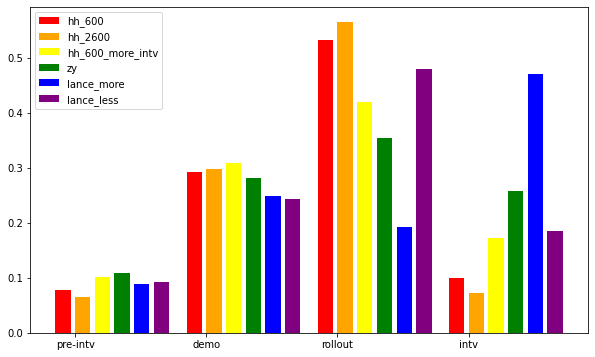

In [14]:
plt.figure(figsize=(10, 6))

colors = ["red", "orange", "yellow", "green", "blue", "purple"]

bar_names = ["pre-intv", "demo", "rollout", "intv"]
weights = [0.1, 10, 1, 15]
#weights = [0.05, 1, 0.1, 3]

c = 0

for i in range(len(datasets)):
    c += 1
    d = datasets[i]
    unique, counts = get_categories_ratio(d)
    x_axis = np.arange(len(unique))
    mean = sum([weights[i] * counts[i] for i in range(len(weights))])
    #print(mean)
    #print([w / mean for w in weights])
    #print()
    print("Dataset: ",  dataset_names[i])
    #print(counts)
    #print([1 / c for c in counts])
    cat_weights = [1 / c for c in counts]
    #print([c / counts[-1] for c in counts])
#     print("demos weight: ", cat_weights[1])
#     print("intv weight: ", cat_weights[-1])
#     print("intv to demos ratio: ", cat_weights[-1] / cat_weights[1])
    print(cat_weights[1])
    print(cat_weights[-1])
    print(cat_weights[-1] / cat_weights[1])
    plt.bar(x_axis + (c-2) * 0.15, counts, width=1 / len(datasets) - 0.05, label = dataset_names[i], align='edge', color=colors[i])


plt.xticks(x_axis, bar_names)
plt.legend()
plt.show()

# Xticks

#plt.xticks(x_axis, team)

===========================================================================
===========================================================================

In [3]:
def get_num_intv_points(dataset):
    out_dataset_path = os.path.expanduser(dataset)

    f = h5py.File(out_dataset_path, "r+")

    demos = sorted(list(f["data"].keys()))

    num_intv_points = []
    
    for ep in demos:
        # store trajectory
        ep_data_grp = f["data/{}".format(ep)]
        random_obs_key = list(ep_data_grp["obs"].keys())[0]
        num_samples = len(ep_data_grp["obs/{}".format(random_obs_key)])
        action_modes = ep_data_grp["action_modes"][()]
        intv_label = action_modes.copy()
        intv_points = []
        for i in range(len(action_modes) - 2):
            a = action_modes[i]
            a_next = action_modes[i + 1]
            a_next_next = action_modes[i + 2]
            if a == ROLLOUT and a_next == INTV and a_next_next == INTV: # need at least 2 intv
                intv_points.append(i + 1)
                
        num_intv_points.append(len(intv_points))

    return num_intv_points

<BarContainer object of 5 artists>

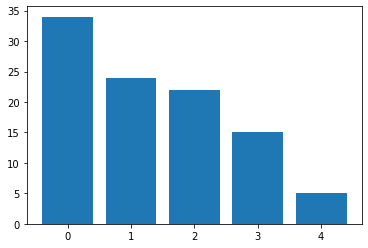

In [14]:
dataset = "/home/huihanl/huihan_hitl/0518_round1_only_image.hdf5"
num_intv_points = get_num_intv_points(dataset)
unique, counts = np.unique(num_intv_points, return_counts=True)
plt.bar(unique, counts)

<BarContainer object of 5 artists>

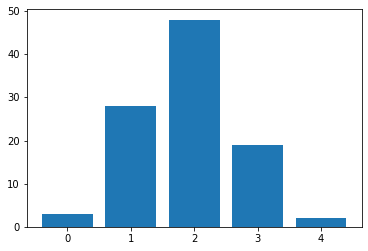

In [15]:
dataset = "/home/huihanl/huihan_hitl/0608_states_square_round1_100.hdf5"
num_intv_points = get_num_intv_points(dataset)
unique, counts = np.unique(num_intv_points, return_counts=True)
plt.bar(unique, counts)

<BarContainer object of 6 artists>

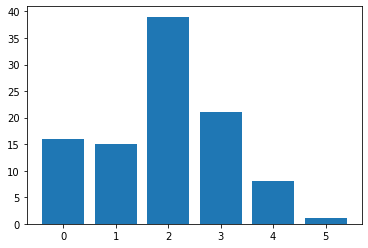

In [16]:
dataset = "/home/huihanl/huihan_hitl/0715_hh_epoch600_more_intv.hdf5"
num_intv_points = get_num_intv_points(dataset)
unique, counts = np.unique(num_intv_points, return_counts=True)
plt.bar(unique, counts)

<BarContainer object of 4 artists>

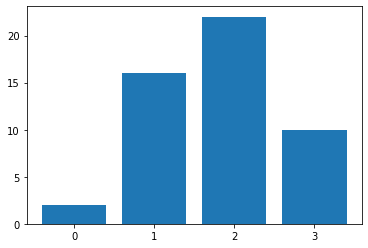

In [23]:
dataset = "/home/huihanl/huihan_hitl/0608_states_square_round1_first50.hdf5"
num_intv_points = get_num_intv_points(dataset)
unique, counts = np.unique(num_intv_points, return_counts=True)
plt.bar([str(u) for u in unique], counts)

<BarContainer object of 5 artists>

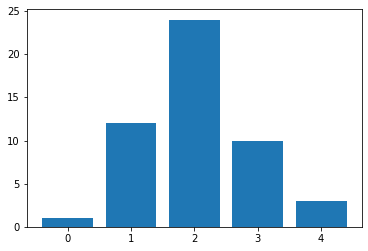

In [21]:
dataset = "/home/huihanl/huihan_hitl/0608_states_square_round1_sec50.hdf5"
num_intv_points = get_num_intv_points(dataset)
unique, counts = np.unique(num_intv_points, return_counts=True)
plt.bar([int(u) for u in unique], counts)

In [98]:
datasets = [
    "0715_hh_epoch600_round01.hdf5",
    "0715_hh_epoch2600_round01.hdf5",
    "0715_hh_epoch600_round01_more_intv_trunc_5.hdf5",
    #"0518_round01_image.hdf5",
    "0608_states_square_round01_150_images.hdf5",
    "lance_round01_more_intv.hdf5",
    "lance_round01_less_intv.hdf5",
]
base_path = "/home/huihanl/huihan_hitl"

datasets = [os.path.join(base_path, d) for d in datasets]

dataset_names = [
    "hh_600",
    "hh_2600",
    "hh_600_more_intv",
    #"hh",
    "zy",
    "lance_more",
    "lance_less",
]